Apply K-Correction to an LRG spectrum

In [34]:
import pandas as pd
import numpy as np

from scipy.interpolate import interp1d

In [19]:
import fitsio

df = pd.DataFrame.from_records(fitsio.read('lrg.fits').byteswap().newbyteorder())

df.head()

,LAMBDA,FLAMBDA
0,1000.65,0.00001
1,1001.51,0.00001
2,1002.36,0.00001
3,1003.23,0.00001
4,1004.09,0.00001


In [20]:
import matplotlib.pyplot as plt

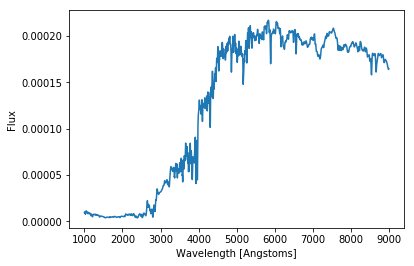

In [22]:
plt.figure()
plt.plot(df['LAMBDA'], df['FLAMBDA'])
plt.xlabel("Wavelength [Angstoms]")
plt.ylabel("Flux")
plt.show()

In [47]:
! head filters/DECam_g.dat

#lambda transmission
3740.0 0.0
3750.0 0.0
3760.0 0.0
3770.0 0.0
3780.0 0.0
3790.0 0.0
3800.0 0.0
3810.0 0.000351429812025
3820.0 0.000437359561568


In [35]:
def read_passband(band):
    """                                                                                                                                                                                                                                                                                                                                                                        
    Read and interolate filter transmission curves                                                                                                                                                                                                                                                                                                                             

    :param band: the single-letter band identifier                                                                                                                                                                                                                                                                                                                             
    :return: transmisison_frequency: interpolated filter transmission as a function of frequency                                                                                                                                                                                                                                                                               
    :return: transmisison_wavelength: interpolated filter transmission as a function of wavelength                                                                                                                                                                                                                                                                             
    """
    #Target filter file associated with band                                                                                                                                                                                                                                                                                                                                   
    filter_file = 'filters/DECam_{}.dat'.format(band)  #[x for x in self.filter_files if x.find('_' + band) != -1][0]

    # Read and format filter transmission info                                                                                                                                                                                                                                                                                                                                 
    passband = pd.read_csv(filter_file,
                           names=['WAVELENGTH', 'TRANSMISSION'],
                           delim_whitespace=True, comment='#')

    # Add boundary terms to cover the whole range                                                                                                                                                                                                                                                                                                                              
    passband.loc[passband.shape[0]] = (1.e-1, 0.0)
    passband.loc[passband.shape[0]] = (4.e+4, 0.0)

    # Convert to frequency using speed of light in angstroms                                                                                                                                                                                                                                                                                                                   
    passband['FREQUENCY'] = 2.99792458e18 / passband['WAVELENGTH'].values

    # Interpolate and return                                                                                                                                                                                                                                                                                                                                                   
    transmission_frequency = interp1d(passband['FREQUENCY'].values, passband['TRANSMISSION'].values, fill_value=0.0)
    transmission_wavelength = interp1d(passband['WAVELENGTH'].values, passband['TRANSMISSION'].values, fill_value=0.0)
    return transmission_frequency, transmission_wavelength


In [44]:
g_transmission_frequency, g_transmission_wavelength = read_passband('g')
r_transmission_frequency, r_transmission_wavelength = read_passband('r')

In [45]:
g_transmission = g_transmission_wavelength(df['LAMBDA'].values)
r_transmission = r_transmission_wavelength(df['LAMBDA'].values)

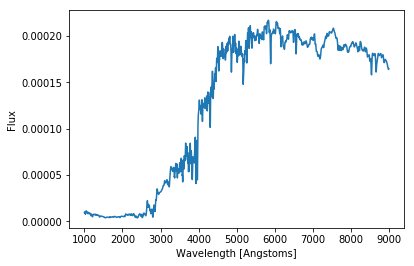

In [41]:
plt.figure()
plt.plot(df['LAMBDA'], df['FLAMBDA'])

plt.xlabel("Wavelength [Angstoms]")
plt.ylabel("Flux")
plt.show()

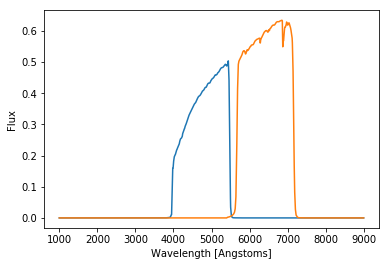

In [46]:

plt.figure()
plt.plot(df['LAMBDA'].values, g_transmission)
plt.plot(df['LAMBDA'].values, r_transmission)

plt.xlabel("Wavelength [Angstoms]")
plt.ylabel("Flux")
plt.show()

In [48]:
from scipy.integrate import quad

In [49]:
g_band_integrand = df['FLAMBDA'].values * g_transmission

In [50]:
g_band_integrand_interpolated = interp1d(df['LAMBDA'].values, g_band_integrand)

In [51]:
result = quad(g_band_integrand_interpolated, df['LAMBDA'].values[0], df['LAMBDA'].values[-1])

/Users/rmorgan/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [53]:
print(result[0])

0.09921667219176956
